In [26]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set visual styling properties
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']
sns.set_style('whitegrid')

# Load data
df = pd.read_csv('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission_data.csv')

# Preprocessing calculations
df['XV_mean'] = df[['XV1', 'XV2', 'XV3']].mean(axis=1)
df['parent_ar_slope_mean'] = df[['parent_ar_slope1', 'parent_ar_slope2', 'parent_ar_slope3']].mean(axis=1)
df['XS/DS'] = df['XV_mean'] / df['parent_ar_slope_mean']

# Error calculations
df['XV_mean_error'] = df[['XV1', 'XV2', 'XV3']].std(axis=1) / (df['XV_mean'] * np.sqrt(3))
df['parent_ar_slope_mean_error'] = df[['parent_ar_slope1', 'parent_ar_slope2', 'parent_ar_slope3']].std(axis=1) / (df['parent_ar_slope_mean'] * np.sqrt(3))
df['XS/DS_rel_error'] = np.sqrt(df['XV_mean_error']**2 + df['parent_ar_slope_mean_error']**2)
df['XS/DS_error'] = df['XS/DS'] * df['XS/DS_rel_error']

# More processing calculations
df['aspect ratio'] = df['width'] / df['XGB_depth_mean']
df['wt_pc_schumm'] = (1 / (df['aspect ratio'] / 255))**(1/1.08)

# Load XGBoost model and make predictions
xgb_reg = xgb.XGBRegressor()
xgb_reg.load_model("/Users/jakegearon/PycharmProjects/based_api/based_tuned_full.pkl")
# Define the inverse power law function for correction
def inverse_power_law(y, a, b):
    return (y / a) ** (1 / b)

# Apply the power-law correction to the discharge values
df['corrected_discharge'] = inverse_power_law(df['discharge_max'], *params)

# Use the corrected discharge, width, and parent_ar_slope_mean to predict the depth
df['XGB_depth'] = xgb_reg.predict(df[['width', 'parent_ar_slope_mean', 'corrected_discharge']])
# More data transformations
df['alluvial_ridge_height1'] = df['alluvial_ridge_elevation1'] - df['floodplain_elevation1']
df['alluvial_ridge_height2'] = df['alluvial_ridge_elevation2'] - df['floodplain_elevation2']
df['alluvial_ridge_height3'] = df['alluvial_ridge_elevation3'] - df['floodplain_elevation3']

# Superelevation calculations
df['A'] = df[['alluvial_ridge_elevation1', 'alluvial_ridge_elevation2', 'alluvial_ridge_elevation3']].sub(df[['water_elevation1', 'water_elevation2', 'water_elevation3']].values).mean(axis=1)
df['B'] = df['XGB_depth']
# Assuming you have a DataFrame named 'df'

# Calculate 'A1' and 'B1' for the first set of columns (2)
df['A1'] = df['alluvial_ridge_elevation1'] - df['water_elevation1']
df['B1'] = df['XGB_depth']

# Calculate 'A2' and 'B2' for the second set of columns (3)
df['A2'] = df['alluvial_ridge_elevation2'] - df['water_elevation2']
df['B2'] = df['XGB_depth']

# Calculate 'A3' and 'B3' for the third set of columns (4)
df['A3'] = df['alluvial_ridge_elevation3'] - df['water_elevation3']
df['B3'] = df['XGB_depth']

# Find the mean of 'A' values (A1, A2, and A3) and 'B' values (B1, B2, and B3)
df['A'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['B'] = df[['B1', 'B2', 'B3']].mean(axis=1)

# Calculate A/B
df['A/B'] = df['A'] / df['B']

# Masks for each category
mask1 = df['method used'] == 1
mask2 = df['method used'] == 2
mask3 = df['method used'] == 3

df.loc[mask1, 'se_max1'] = df['alluvial_ridge_height1'] / df['XGB_depth']
df.loc[mask1, 'se_max2'] = df['alluvial_ridge_height2'] / df['XGB_depth']
df.loc[mask1, 'se_max3'] = df['alluvial_ridge_height3'] / df['XGB_depth']


df.loc[mask2, 'se_max1'] = df['alluvial_ridge_height1'] / (df['alluvial_ridge_elevation1'] - (df['water_elevation1']))
df.loc[mask2, 'se_max2'] = df['alluvial_ridge_height2'] / (df['alluvial_ridge_elevation2'] - (df['water_elevation2']))
df.loc[mask2, 'se_max3'] = df['alluvial_ridge_height3'] / (df['alluvial_ridge_elevation3'] - (df['water_elevation3']))

# When A/B > 4
df.loc[mask3, 'se_max1'] = df['alluvial_ridge_height1'] / (df['alluvial_ridge_elevation1'] - (df['water_elevation1']-df['XGB_depth']))  # Fill this in with the relevant formula
df.loc[mask3, 'se_max2'] = df['alluvial_ridge_height2'] / (df['alluvial_ridge_elevation2'] - (df['water_elevation2']-df['XGB_depth']))  # Fill this in with the relevant formula
df.loc[mask3, 'se_max3'] = df['alluvial_ridge_height3'] / (df['alluvial_ridge_elevation3'] - (df['water_elevation3']-df['XGB_depth']))  # Fill this in with the relevant formula


df['se_std'] = df[['se_max1', 'se_max2', 'se_max3']].std(axis=1)
df['superelevation_ov_mean'] = df[['se_max1', 'se_max2', 'se_max3']].mean(axis=1)
df['superelevation_sem'] = df[['se_max1', 'se_max2', 'se_max3']].sem(axis=1) / 3

# Additional processing
df['AR_mean'] = df[['AR_FULL_W1', 'AR_FULL_W2', 'AR_FULL_W3']].mean(axis=1)
df['AR_SE'] = df[['AR_FULL_W1', 'AR_FULL_W2', 'AR_FULL_W3']].std(axis=1) / np.sqrt(3)

df['lambda_val'] = (df['AR_mean'] - df['width']) / df['width']
df['lambda_rel_error'] = df['AR_SE'] / df['AR_mean']
df['lambda_error'] = df['lambda_val'] * df['lambda_rel_error']

df['product_rel_error'] = np.sqrt(df['XS/DS_rel_error']**2 + df['lambda_rel_error']**2)
df['product_error'] = df['XS/DS'] * df['lambda_val'] * df['product_rel_error']

df['spr'] = np.log((df['normalized_dist'] / df['parent_ar_slope_mean']) + 1)
df['Geomorphology'] = df['Geomorphology'].replace({'Mountain Front': 'Alluvial Plain'})

# Filtering out unwanted avulsion names
avulsions_to_exclude = ['V12', 'A031', 'PI0269-1_1996', 'R11.1', 'R14', 'R17.2', 'R18', 'R30.2', 'V5_2', 'V8',
                        'JA_12_Eritrea', 'B13', 'B15', 'H4', 'G3', 'G22', 'G24', 'H010']

df = df[~df['Avulsion Name'].isin(avulsions_to_exclude)]

df['prod'] = df['superelevation_ov_mean'] * df['XS/DS'] * df['lambda_val']
df['lambdagamma']=df['lambda_val']*df['XS/DS']
df['AB_flag'] = df['A'] > df['B']
dff = df.filter(['Avulsion Name', 'superelevation_ov_mean', 'lambdagamma', 'method used', 'XS/DS', 'lambda_val', 'A/B', 'A', 'B', 'AB_flag', 'prod'])

dff['AB_flag'].value_counts()
dff

,Avulsion Name,superelevation_ov_mean,lambdagamma,method used,XS/DS,lambda_val,A/B,A,B,AB_flag,prod
0,A002,1.375000,3.553461,2,0.857732,4.142857,3.525587,8.000000,2.269126,True,4.886009
1,A004,0.600000,2.054064,2,0.316487,6.490196,1.307339,3.000000,2.294738,True,1.232438
2,A012,0.166240,134.794308,3,21.813187,6.179487,0.224372,2.233333,9.953700,False,22.408152
3,A018,1.166667,2.561014,2,0.480190,5.333333,1.622485,2.000000,1.232677,True,2.987850
4,AFR0211_1998,0.164944,127.625400,1,2.509749,50.851852,0.239029,2.850000,11.923261,False,21.051003
5,ANGO2_2003,1.120229,5.544941,1,0.943396,5.877637,0.763432,2.246667,2.942851,False,6.211602
6,ARG_001_2001,1.219924,101.421687,1,7.349398,13.800000,0.725360,1.833333,2.527479,False,123.726795
7,B1,1.149312,58.333003,2,3.325397,17.541667,1.517393,4.761435,3.137904,True,67.042797
8,B10,0.472149,235.305232,1,13.934783,16.886179,0.407728,5.000000,12.263089,False,111.099028
9,B12,0.843990,218.763839,3,13.387387,16.341040,1.724738,8.000000,4.638386,True,184.634407


In [298]:
df['AB_flag'].value_counts()
23 / (23+35)

0.39655172413793105

In [278]:
25/58

0.43103448275862066

In [28]:
import numpy as np
import pandas as pd

n_simulations = 10000

ridge_elev_error = 0.6
floodplain_elev_error = 0.6
water_surface_elev_error = 0.25
xgb_depth_error = 0.6



superelevation_column = 'superelevation'
uncertainty_column = 'uncertainty'

for index, row in df.iterrows():
    all_superelevations = []

    for _ in range(n_simulations):
        i = np.random.choice([1, 2, 3])

        ridge_height = row[f'alluvial_ridge_elevation{i}'] - row[f'floodplain_elevation{i}']
        sampled_ridge_height = ridge_height + np.random.triangular(-ridge_elev_error, 0, ridge_elev_error)
        sampled_water_surface_elevation = row[f'water_elevation{i}'] + np.random.triangular(-water_surface_elev_error, 0, water_surface_elev_error)
        sampled_xgb_depth = row['XGB_depth'] + np.random.triangular(-xgb_depth_error, 0, xgb_depth_error)

        if row['method used'] == 1:
            superelevation = sampled_ridge_height / sampled_xgb_depth
        elif row['method used'] == 2:
            superelevation = sampled_ridge_height / (row[f'alluvial_ridge_elevation{i}'] - sampled_water_surface_elevation)
        elif row['method used'] == 3:
            superelevation = sampled_ridge_height / (row[f'alluvial_ridge_elevation{i}'] - (sampled_water_surface_elevation - sampled_xgb_depth))

        all_superelevations.append(superelevation)

    df.at[index, superelevation_column] = np.mean(all_superelevations)
    df.at[index, uncertainty_column] = np.std(all_superelevations)

boot_df = df  # Now df contains all the needed columns.
# Normalize the A/B values to be between 0 and 1


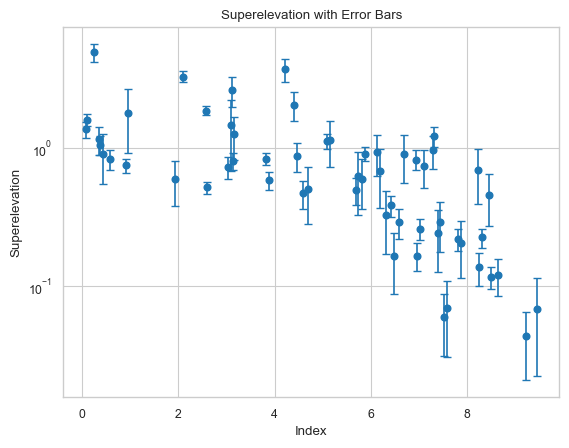

In [29]:
import matplotlib.pyplot as plt

x = boot_df.spr  # Assuming the index represents the x-axis values
y = boot_df['superelevation']
y_err = boot_df['uncertainty']

# Calculate the average of upper and lower error values
y_err_avg = (boot_df['uncertainty'] + boot_df['uncertainty']) / 2

plt.errorbar(x, y, yerr=y_err_avg, fmt='o', capsize=3)
plt.xlabel('Index')
plt.ylabel('Superelevation')
plt.title('Superelevation with Error Bars')
plt.grid(True)
plt.yscale('log')
plt.show()

### Figure 1 done in QGIS and illustrator, but here is the required historgram fig needed for it to come together

In [276]:
boot_df.filter(['spr','superelevation', 'uncertainty', 'Avulsion Name']).sort_values('spr')

,spr,superelevation,uncertainty,Avulsion Name
0,0.079797,1.474255,0.179801,A002
54,0.094619,1.617775,0.170280,V13
13,0.249213,4.743024,0.734485,B6
3,0.345879,1.092106,0.272266,A018
33,0.372852,1.019480,0.165817,JA_8_India_2004_2004
12,0.432284,0.778606,0.371363,B4
11,0.588696,0.780721,0.141744,B2
15,0.914424,0.783623,0.090493,BETSIBOKA_2004
56,0.950401,1.356987,0.875904,V9
1,1.938354,0.541616,0.214507,A004


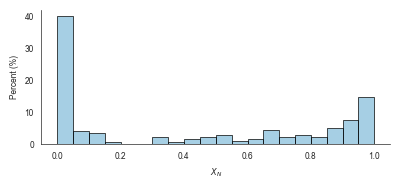

In [462]:
# df_hist = pd.read_excel('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth/data_to_submit.xlsx').dropna(subset=['Avulsion Name', 'geometry',
#                                                                                                                             'dist_mtn_front_to_avulsion',
# df_hist = gpd.read_file('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/pop_zonal.geojson')
# df_hist['spr'] = np.log((df_hist['normalized_dist']/df['parent_ar_slope_mean'])+1)
#                                                                                                                             'total_transport distance',
#'normalized_dist'])
import geopandas as gpd
df_hist = gpd.read_file('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/pop_zonal.geojson')
df_hist['spr'] = np.log((df_hist['normalized_dist']/df['parent_ar_slope_mean'])+1)
df_hist['normalized_dist'] = df_hist['normalized_dist'].astype(float)

# Set font size and style
sns.set(font_scale=1.0, style="white")

# Create figure and axes
fig, ax = plt.subplots(figsize=(4.5, 1.75))

# Plot histogram
sns.histplot(data=df_hist, x='normalized_dist', kde=False, fill=True,
             alpha=.5, edgecolor='black', stat="percent", binwidth=.05, color='#4FA0CA',linewidth=.50)

# Set axis labels and title
ax.set_xlabel('$X_N$', fontsize=6)
ax.set_ylabel('Percent (%)', fontsize=6)

ax.tick_params(axis='both', which='major', labelsize=6, width=0, length=2)
ax.spines['bottom'].set_linewidth(0.5)  # Adjust the line width of the x-axis
ax.spines['left'].set_linewidth(0.5)    # Adjust the line width of the y-axis
sns.despine()
# Save figure
#plt.savefig('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/rebirth/DistHist.pdf', bbox_inches='tight')

# Show plot
plt.show()


In [373]:
data = [
    ["Indonesia", 66.033907],
    ["Argentina", 66.363962],
    ["Cyprus", 48.437801],
    ["India", 68.516289],
    ["People's Republic of China", 42.793618],
    ["France", 55.236897],
    ["South Korea", 43.272558],
    ["South Africa", 68.943652],
    ["Lithuania", 59.382433],
    ["Brazil", 57.594965],
    ["Czech Republic", 49.566262],
    ["Germany", 48.471918],
    ["Estonia", 60.122871],
    ["Latvia", 61.212536],
    ["Sweden", 58.857821],
    ["Finland", 59.860711],
    ["Luxembourg", 43.891102],
    ["Belgium", 37.563061],
    ["Turkey", 57.619970],
    ["Spain", 53.400327],
    ["Denmark", 55.345361],
    ["Romania", 56.866002],
    ["Hungary", 53.375399],
    ["Slovakia", 55.908528],
    ["Poland", 54.110025],
    ["Ireland", 59.063961],
    ["United Kingdom", 52.737709],
    ["Greece", 53.788649],
    ["Austria", 53.506250],
    ["Italy", 42.543722],
    ["Croatia", 53.481072],
    ["Slovenia", 53.256296],
    ["Saudi Arabia", 55.757394],
    ["Bulgaria", 55.662894],
    ["Portugal", 46.100522],
    ["United States of America", 54.884098],
    ["Canada", 57.569389],
    ["Mexico", 65.726648],
    ["Australia", 55.170738],
    ["Japan", 49.164411],
    ["Malta", 30.840760],
    ["Netherlands", 40.603666]
]

eu_countries = {"Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", 
               "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", 
               "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", 
               "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"}

non_eu_dict = {country[0]: country[1] for country in data if country[0] not in eu_countries}

eu_mean = np.mean([48.437801, 55.236897, 59.382433, 49.566262, 48.471918, 60.122871,
         61.212536, 58.857821, 59.860711, 43.891102, 37.563061, 53.400327,
         55.345361, 56.866002, 53.375399, 55.908528, 54.110025, 59.063961,
        53.788649, 53.506250, 42.543722, 53.481072, 53.256296, 55.662894
        ,46.100522, 30.840760, 40.603666])
eu_mean
non_eu_dict['EU'] = eu_mean
final_dict_w_eu = non_eu_dict

In [374]:
final_dict_df = pd.DataFrame(list(final_dict_w_eu.items()), columns=['Country', 'GRDI_mean'])




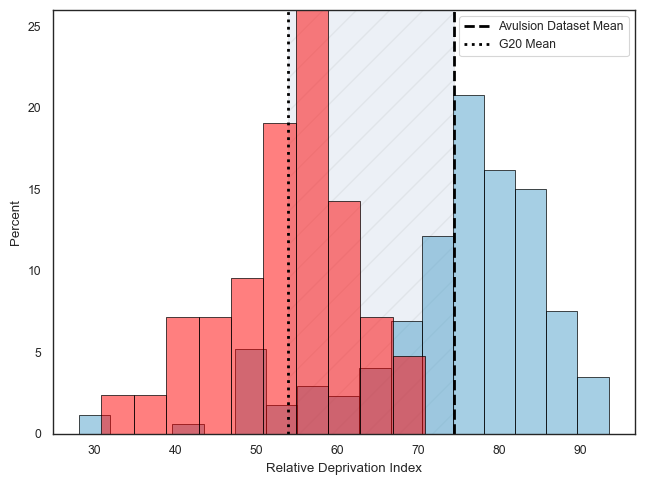

In [458]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your histplot code
plt.fill_between([df_hist['GRDI_mean'].mean(), countries['GRDI_mean'].mean()], 0, 30,
                  hatch='/', edgecolor='gray', alpha=0.1, zorder=0)  # Set xmin and xmax
sns.histplot(data=countries, x='GRDI_mean', kde=False, fill=True,
             alpha=.5, edgecolor='black', stat="percent", color='red',linewidth=.50, binwidth=4, zorder=2)
sns.histplot(data=df_hist, x='GRDI_mean', kde=False, fill=True,
             alpha=.5, edgecolor='black', stat="percent", color='#4FA0CA',linewidth=.50, zorder=1)

plt.axvline(df_hist['GRDI_mean'].mean(), c='black', ls='--', lw=2, label='Avulsion Dataset Mean')
plt.axvline(countries['GRDI_mean'].mean(), c='black', ls=':', lw=2, label='G20 Mean')
plt.ylim(0, 26)
plt.legend()
plt.xlabel('Relative Deprivation Index')
plt.tight_layout()
plt.savefig('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/G20_fig.png', dpi=300)
plt.show()


In [318]:
#df_hist.to_csv('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/XN_hist_data.csv')

### Figure 2

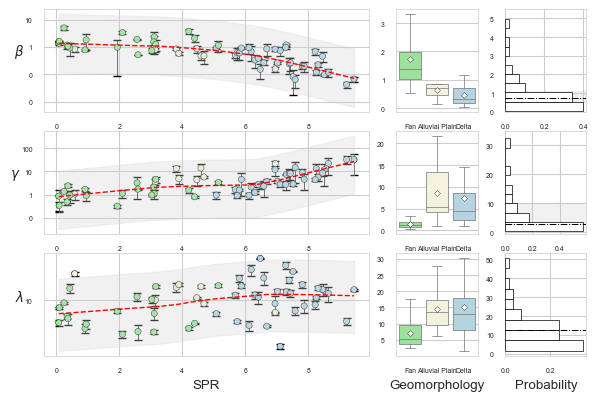

In [211]:
from sklearn.utils import resample

meanprops = {
    "marker": "D",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "3",
    "markeredgewidth": 0.25
}

flierprops = {
    "marker": "^",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "3",
    "markeredgewidth": 0.5
}
palette = [ '#90EE90', '#F5F5DC', '#ADD8E6']
#palette = ['#00C853', '#EF6C00','#304FFE']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def plot_scatter_with_lowess(ax, data, x_col, y_col, frac=0.6, len_boot=5000, color_data=None, palette=None, edgecolor='black'):
    # Extract data from DataFrame
    x = data[x_col]
    y = np.log(data[y_col])  # Log-transform y values

    # If color_data is specified, use hue in scatterplot
    if color_data:
        sns.scatterplot(x=data[x_col], y=data[y_col], hue=data[color_data], s=20, ax=ax, palette=palette, hue_order=['Fan', 'Alluvial Plain', 'Delta'], edgecolor=edgecolor)
    else:
        sns.scatterplot(x=data[x_col], y=data[y_col], ax=ax)

    # Fit the LOWESS model to the log-transformed data
    lowess_results = lowess(y, x, frac=frac, it=5)
    y_predicted = lowess_results[:, 1]
    residuals = y - y_predicted

    # Perform bootstrapping to estimate the confidence intervals in log space
    y_bootstrapped = np.empty((len_boot, len(y)))
    for i in range(len_boot):
        residuals_bootstrap = resample(residuals)
        y_bootstrapped[i] = y_predicted + residuals_bootstrap

    # Calculate the lower and upper bounds of the confidence intervals in log space
    y_ci_lower = np.percentile(y_bootstrapped, 2.5, axis=0)
    y_ci_upper = np.percentile(y_bootstrapped, 97.5, axis=0)

    # Transform the predicted values and confidence intervals back to linear space for plotting
    y_predicted = np.exp(y_predicted)
    y_ci_lower = np.exp(y_ci_lower)
    y_ci_upper = np.exp(y_ci_upper)

    # Plot the LOWESS fit and the confidence intervals
    ax.plot(lowess_results[:, 0], y_predicted, color='red', linestyle='--', linewidth=1.)
    ax.fill_between(lowess_results[:, 0], y_ci_lower, y_ci_upper, color='lightgray', alpha=0.3)  # Lighter gray

    # Formatting and labeling
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend().set_visible(False)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

    return ax

# Then include the custom function before plotting:
def format_func(value, tick_number):
    return "{:.0f}".format(value)
    
def plot_boxplot(ax, x_data, y_data, order, ylabel=''):
    sns.boxplot(data=df, x=x_data, y=y_data, showfliers=False, flierprops=flierprops,
                showmeans=True, meanprops=meanprops,
                order=order, ax=ax, palette=palette, linewidth=0.5)  # Set linewidth to desired value
    ax.grid(axis='y', visible=True)
    ax.set_ylabel(ylabel, labelpad=10, rotation=0)
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, fontsize=5)

# Create a figure
fig_width, fig_height = 7,4.5  # Adjusted width to accommodate the new column
fig = plt.figure(figsize=(fig_width, fig_height))

df = df.dropna(subset=['XS/DS', 'spr', 'superelevation_ov_mean', 'lambda_val', 'se_std'])

# Divide the figure into 9 rows and 3 columns
gs1 = gridspec.GridSpec(9, 3, width_ratios=[2, .5, .5], wspace=.17, hspace=.9)  # Added a new column

# Scatter plots on left
ax0 = fig.add_subplot(gs1[:3, 0])

ax0.errorbar(boot_df['spr'], boot_df['superelevation_ov_mean'], yerr=boot_df['uncertainty'], capsize=3, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax0, df, 'spr', 'superelevation_ov_mean', color_data='Geomorphology', palette=palette)
ax0.set_ylabel(r'$\beta$', rotation=0)
ax0.set_xlabel('')


ax1 = fig.add_subplot(gs1[3:6, 0])
ax1.errorbar(df['spr'], df['XS/DS'], yerr=df['XS/DS_error'], capsize=3, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)

plot_scatter_with_lowess(ax1, df, 'spr', 'XS/DS', color_data='Geomorphology', palette=palette)

ax1.set_ylabel(r'$\gamma$', rotation=0)


ax2 = fig.add_subplot(gs1[6:, 0])
# Add your plot for ax2, for example:
ax2.errorbar(df['spr'], df['lambda_val'], yerr=df['lambda_error'], capsize=3, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax2, df, 'spr', 'lambda_val', frac=0.7, color_data='Geomorphology', palette=palette)

ax2.set_ylabel(r'$\lambda$', rotation=0)
ax2.set_xlabel('SPR')

# Boxplots in the middle
ax3 = fig.add_subplot(gs1[0:3, 1])
plot_boxplot(ax3, 'Geomorphology', 'superelevation_ov_mean', ['Fan', 'Alluvial Plain', 'Delta'])
ax3.set_xlabel('')
ax4 = fig.add_subplot(gs1[3:6, 1])
plot_boxplot(ax4, 'Geomorphology', 'XS/DS', ['Fan', 'Alluvial Plain', 'Delta'])
ax4.set_xlabel('')

ax5 = fig.add_subplot(gs1[6:9, 1])
plot_boxplot(ax5, 'Geomorphology', 'lambda_val', ['Fan', 'Alluvial Plain', 'Delta'])
ax5.set_xlabel('')
ax5.set_xlabel('Geomorphology')


# Histograms on the right
ax6 = fig.add_subplot(gs1[0:3, 2])
sns.histplot(data=df, y='superelevation_ov_mean', bins=10, edgecolor='k', color='white', alpha=1, stat="probability", ax=ax6, zorder=3, linewidth=.5)
ax6.set_ylabel('')
ax6.set_xlabel('')
ax6.axhspan(.5, 1.1, color='#BDBDBD', alpha=.2, fill=True, zorder=1)
ax6.set_ylim(0, 5.5)
median_superelevation = df['superelevation_ov_mean'].median()
ax6.axhline(y=median_superelevation, color='black', linestyle='-.', linewidth=.75, zorder=4)

ax7 = fig.add_subplot(gs1[3:6, 2])
sns.histplot(data=df, y='XS/DS', bins=10, edgecolor='k', color='white', alpha=1, stat="probability", ax=ax7, zorder=3, linewidth=.5)
ax7.set_ylabel('')
ax7.set_xlabel('')
# Plotting the right histogram with shaded area
ax7.axhspan(3, 10, color='#BDBDBD', alpha=0.2, zorder=1)
ax7.set_ylim(-.5, 35)
median_XS_DS = df['XS/DS'].median()
ax7.axhline(y=median_XS_DS, color="black", linestyle='-.', linewidth=.75, zorder=4)


ax8 = fig.add_subplot(gs1[6:9, 2])
sns.histplot(data=df, y='lambda_val', edgecolor='k', color='white', alpha=1, stat="probability", ax=ax8, zorder=3, linewidth=.5)
ax8.set_ylabel('')
# Add vertical lines for the mean in the lambda histogram
mean_lambda = df['lambda_val'].mean()
ax8.axhline(y=mean_lambda, color="black", linestyle='-.', linewidth=.75, zorder=4)


all_axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for ax in all_axes:
    for spine in ax.spines.values():
        spine.set_linewidth(.5)
    ax.tick_params(axis='both', labelsize=5)

#plt.savefig('FIGURE2.pdf')
#plt.savefig('submission/FIGURE2.png', dpi=300)
plt.show()


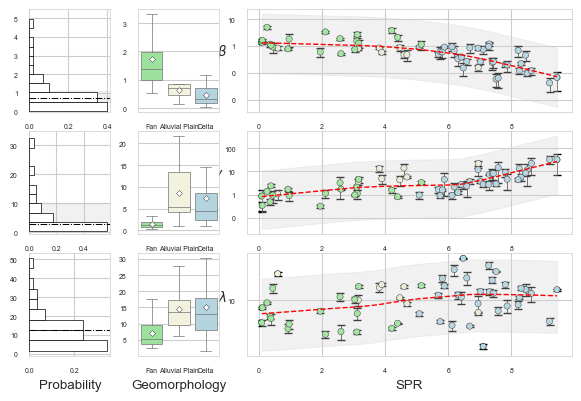

In [284]:
# Create a figure
fig_width, fig_height = 7, 4.5  # Adjusted width to accommodate the new column
fig = plt.figure(figsize=(fig_width, fig_height))

# Divide the figure into 9 rows and 3 columns
gs1 = gridspec.GridSpec(9, 3, width_ratios=[.5, .5, 2], wspace=.17, hspace=.9)  # Updated width ratios

# Scatter plots on the left
ax0 = fig.add_subplot(gs1[:3, 2])  # Updated index for the first column

ax0.errorbar(boot_df['spr'], boot_df['superelevation'], yerr=boot_df['uncertainty'], capsize=3, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax0, df, 'spr', 'superelevation_ov_mean', color_data='Geomorphology', palette=palette)
ax0.set_ylabel(r'$\beta$', rotation=0)
ax0.set_xlabel('')

ax1 = fig.add_subplot(gs1[3:6, 2])  # Updated index for the first column
ax1.errorbar(df['spr'], df['XS/DS'], yerr=df['XS/DS_error'], capsize=3, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax1, df, 'spr', 'XS/DS', color_data='Geomorphology', palette=palette)
ax1.set_ylabel(r'$\gamma$', rotation=0)

ax2 = fig.add_subplot(gs1[6:, 2])  # Updated index for the first column
ax2.errorbar(df['spr'], df['lambda_val'], yerr=df['lambda_error'], capsize=3, ls='none', lw=.5, color='black', markeredgecolor='black', markersize=8, zorder=1)
plot_scatter_with_lowess(ax2, df, 'spr', 'lambda_val', frac=0.7, color_data='Geomorphology', palette=palette)
ax2.set_ylabel(r'$\lambda$', rotation=0)
ax2.set_xlabel('SPR')

# Boxplots in the middle (unchanged)
ax3 = fig.add_subplot(gs1[0:3, 1])
plot_boxplot(ax3, 'Geomorphology', 'superelevation_ov_mean', ['Fan', 'Alluvial Plain', 'Delta'])
ax3.set_xlabel('')
ax4 = fig.add_subplot(gs1[3:6, 1])
plot_boxplot(ax4, 'Geomorphology', 'XS/DS', ['Fan', 'Alluvial Plain', 'Delta'])
ax4.set_xlabel('')

ax5 = fig.add_subplot(gs1[6:9, 1])
plot_boxplot(ax5, 'Geomorphology', 'lambda_val', ['Fan', 'Alluvial Plain', 'Delta'])
ax5.set_xlabel('')
ax5.set_xlabel('Geomorphology')

# Histograms on the right (unchanged)
ax6 = fig.add_subplot(gs1[0:3, 0])
sns.histplot(data=df, y='superelevation_ov_mean', bins=10, edgecolor='k', color='white', alpha=1, stat="probability", ax=ax6, zorder=3, linewidth=.5)
ax6.set_ylabel('')
ax6.set_xlabel('')
ax6.axhspan(.5, 1.1, color='#BDBDBD', alpha=.2, fill=True, zorder=1)
ax6.set_ylim(0, 5.5)
median_superelevation = df['superelevation_ov_mean'].median()
ax6.axhline(y=median_superelevation, color='black', linestyle='-.', linewidth=.75, zorder=4)

ax7 = fig.add_subplot(gs1[3:6, 0])
sns.histplot(data=df, y='XS/DS', bins=10, edgecolor='k', color='white', alpha=1, stat="probability", ax=ax7, zorder=3, linewidth=.5)
ax7.set_ylabel('')
ax7.set_xlabel('')
# Plotting the right histogram with shaded area
ax7.axhspan(3, 10, color='#BDBDBD', alpha=0.2, zorder=1)
ax7.set_ylim(-.5, 35)
median_XS_DS = df['XS/DS'].median()
ax7.axhline(y=median_XS_DS, color="black", linestyle='-.', linewidth=.75, zorder=4)

ax8 = fig.add_subplot(gs1[6:9, 0])
sns.histplot(data=df, y='lambda_val', edgecolor='k', color='white', alpha=1, stat="probability", ax=ax8, zorder=3, linewidth=.5)
ax8.set_ylabel('')
# Add vertical lines for the mean in the lambda histogram
mean_lambda = df['lambda_val'].mean()
ax8.axhline(y=mean_lambda, color="black", linestyle='-.', linewidth=.75, zorder=4)

all_axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for ax in all_axes:
    for spine in ax.spines.values():
        spine.set_linewidth(.5)
    ax.tick_params(axis='both', labelsize=5)

plt.savefig('FIGURE2.pdf')
#plt.savefig('submission/FIGURE2.png', dpi=300)
plt.show()


In [289]:
df.groupby(['Geomorphology'])['superelevation_ov_mean'].mean()
df['Geomorphology'].value_counts()

Geomorphology
Delta             31
Fan               19
Alluvial Plain     8
Name: count, dtype: int64

In [202]:
df['lambda_val'].median()

10.984848484848484

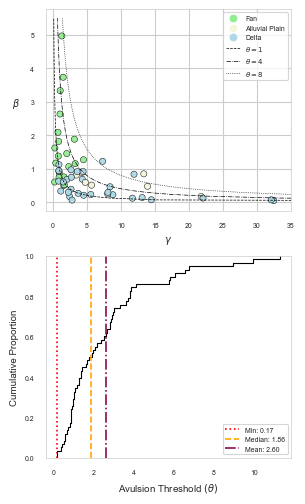

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.0)
sns.set_style('whitegrid')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 5
palette = [ '#90EE90', '#F5F5DC', '#ADD8E6']

fig, axes = plt.subplots(2, 1, figsize=(3, 5)) #3, 5

# First subplot
# Define beta values
beta = np.linspace(0.01, 5.5, 100)

# Define constants
#lambda_val = 11  # Assumption
thetas = [1, 4, 8]
colors = ['#003366', '#8B0000', '#4DB6AC']
lss = ['--', '-.', ':']

#axes[0].errorbar(x=df['XS/DS'], y=df['superelevation_ov_mean'], yerr=boot_df['uncertainty'], xerr=df['product_error'], capsize=2, capthick=.1, ls='none', lw=.2, color='black', markeredgecolor='black', markersize=2, zorder=1)
sns.scatterplot(data=df, x=df['XS/DS'], y='superelevation_ov_mean', hue='Geomorphology', hue_order=['Fan', 'Alluvial Plain', 'Delta'], s=20, palette=palette, edgecolor='k', ax=axes[0], alpha=0.95)

# Calculate and plot gamma_lambda for each theta value
for i, theta in enumerate(thetas):
    gamma_lambda = (theta) / beta
    axes[0].plot(gamma_lambda, beta, lw=.5, ls=lss[i], color='k', label=rf'$\theta = {theta}$')

axes[0].grid()
axes[0].legend(fontsize=5)
axes[0].set_ylabel(r'$\beta$', fontsize=7, rotation=0, labelpad=10)
axes[0].set_xlabel(r'$\gamma$', fontsize=7)
axes[0].set_xlim(-1, 35)
#axes[0].set_yscale('log')

#axes[0].set_xscale('log')
axes[0].tick_params(axis='both', which='major', labelsize=7)
axes[0].grid()

# Second subplot
# Data for the ECDF
data_values = df['XS/DS'] * df['superelevation_ov_mean']

# Statistics
min_val = data_values.min()
mean_val = data_values.mean()
median_val = data_values.median()

# Plotting the ECDF
sns.ecdfplot(data=data_values, ax=axes[1], color='k', lw=.8)

# Adding vertical lines for min, mean, and median
axes[1].axvline(x=min_val, color='red', linestyle=':', label=f"Min: {min_val:.2f}")
axes[1].axvline(x=median_val, color='orange', linestyle='--', label=f"Median: {median_val:.2f}")
axes[1].axvline(x=mean_val, color='#880E4F', linestyle='-.', label=f"Mean: {mean_val:.2f}")

axes[1].set_xlabel(r"Avulsion Threshold $(\theta)$", fontsize=7)
axes[1].set_ylabel("Cumulative Proportion", fontsize=7)
axes[1].legend(fontsize=5)
axes[1].grid()
axes[1].tick_params(axis='both', which='major', labelsize=7)

for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(.5)
    ax.tick_params(axis='both', labelsize=5)
plt.tight_layout()
#plt.savefig('Combined_Figure.pdf')
plt.savefig('submission/Combined_Figure_nolambda.png')
plt.show()


<Axes: ylabel='Count'>

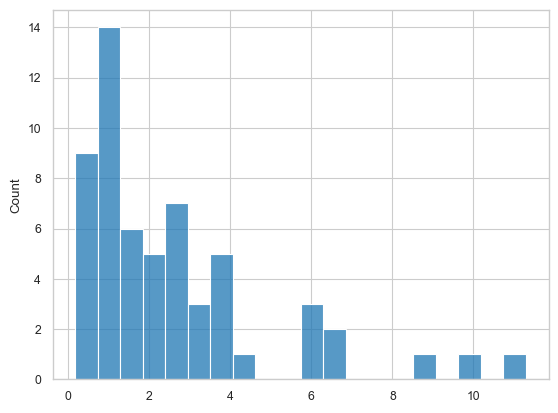

In [43]:
sns.histplot(data=df, x=df['XS/DS']*df['superelevation_ov_mean'], bins=20)

## Methods and Supplement


In [44]:
(df['XS/DS']*df['superelevation_ov_mean']).describe()

count    58.000000
mean      2.598633
std       2.409897
min       0.168985
25%       0.937339
50%       1.863430
75%       3.234654
max      11.298816
dtype: float64

In [4]:
import geopandas as gpd
gdf = gpd.read_file("/Users/jakegearon/PycharmProjects/Trampush_Rivers/trampy_updater.geojson").dropna(subset='n')
grouped = gdf.groupby("Gage")

# Create an empty list to store the Series
result_list = []

# Iterate through each group
for group_name, group_data in grouped:

    # Find the row with the largest value in the "n" column within each group
    largest_row = group_data.loc[group_data['n'].idxmax()]

    # Convert the row to a Series and append it to the list
    result_list.append(pd.Series(largest_row))

# Create a DataFrame from the list of Series
gdf = pd.concat(result_list, axis=1).T
gdf.columns

Index(['Source', 'Inclusion', 'Agency', 'Gage', 'Location', 'Country', 'State',
       'Lat [deg]', 'Lon [deg]', 'DA [km2]', 'Qbf [m3/s]', 'Abf [m2]',
       'Wbf [m]', 'Hbf [m]', 'S [-]', 'D50 [mm]', 'D84 [mm]', 'Notes',
       'RA_dis_m3_pyr', 'RA_dis_m3_pmn', 'RA_dis_m3_pmx', 'RA_id', 'n',
       'distance', 'feature_x', 'feature_y', 'nearest_x', 'nearest_y',
       'geometry'],
      dtype='object')

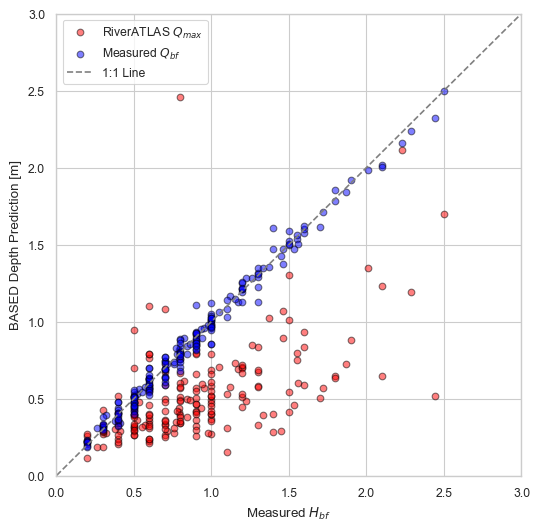

In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xgboost as xgb
import matplotlib.pyplot as plt

# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/trampyupdater.geojson").dropna(subset='n')

# Group the data by the river identifier ("Gage" column)
grouped = gdf.groupby("Gage")

# Create an empty list to store the Series
result_list = []

# Iterate through each group to find the row with the largest value in the "n" column
for group_name, group_data in grouped:
    largest_row = group_data.loc[group_data['n'].idxmax()]
    result_list.append(pd.Series(largest_row))

# Create a DataFrame from the list of Series
gdf = pd.concat(result_list, axis=1).T

# Filter the DataFrame and remove specific locations
locations_to_remove = [
    'Ditch Run near Hancock',
    'Potomac River Tribuatary near Hancock. Md.',
    'Clark Fork tributary near Drummond',
    'Richards Creek near Libby MT',
    'Ohio Brush Creek near West Union',
    "Floyd's Fork at Fisherville"
]
#gdf.to_file("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/trampyupdater_1n.geojson")
gdf = gdf[~gdf["Location"].isin(locations_to_remove)]

gdf = gdf.dropna(subset=['Qbf [m3/s]', 'RA_dis_m3_pmx_2'])
# Select specific columns from the DataFrame
gdf = gdf.filter(['Qbf [m3/s]', 'Wbf [m]', 'Hbf [m]', 'S [-]', 'RA_dis_m3_pmx_2', 'Location'])

# Load the XGBoost model
xgb_reg = xgb.XGBRegressor()
xgb_reg.load_model("/Users/jakegearon/PycharmProjects/based_api/based_tuned_no_trampush.pkl")

# Prepare input data for prediction
guesswork1 = gdf[['Wbf [m]', 'S [-]', 'RA_dis_m3_pmx_2']].astype(float)
gdf['XGB_depth_RA'] = xgb_reg.predict(guesswork1)
guesswork2 = gdf[['Wbf [m]', 'S [-]', 'Qbf [m3/s]']].astype(float)
gdf['XGB_depth_VAL'] = xgb_reg.predict(guesswork2)

# Create a scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
plt.plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')

plt.xlabel('Measured $H_{bf}$')
plt.ylabel('BASED Depth Prediction [m]')
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()
plt.show()


In [208]:
from sklearn.metrics import mean_squared_error

# Extract the columns into Series for clarity
observed = gdf['Hbf [m]']
predicted = gdf['XGB_depth_RA_corr']

# Calculate the RMSE
rmse = mean_squared_error(observed, predicted, squared=False)  # squared=False returns the RMSE directly

print(f"RMSE: {rmse}")


RMSE: 0.42738867799187513


In [9]:
import geopandas as gpd
gdf = gpd.read_file("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/trampyupdater.geojson").dropna(subset='n')


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def inverse_power_law(y, a, b):
    return (y / a) ** (1 / b)
gdf['corrected_RA'] = inverse_power_law(gdf['RA_dis_m3_pmx_2'], *params)
mae_corrected = mean_absolute_error(gdf['Qbf [m3/s]'], gdf['corrected_RA'])
rmse_corrected = mean_squared_error(gdf['Qbf [m3/s]'], gdf['corrected_RA'], squared=False)
r2_corrected = r2_score(gdf['Qbf [m3/s]'], gdf['corrected_RA'])
bias_corrected = (gdf['corrected_RA'] - gdf['Qbf [m3/s]']).mean()
percent_bias_corrected = 100 * bias_corrected / gdf['Qbf [m3/s]'].mean()

print(f"Corrected - MAE: {mae_corrected:.2f}")
print(f"Corrected - RMSE: {rmse_corrected:.2f}")
print(f"Corrected - R-squared: {r2_corrected:.2f}")
print(f"Corrected - Bias: {bias_corrected:.2f}")
print(f"Corrected - Percent Bias: {percent_bias_corrected:.2f}%")


Corrected - MAE: 19.72
Corrected - RMSE: 59.93
Corrected - R-squared: -1.90
Corrected - Bias: 3.19
Corrected - Percent Bias: 11.08%


In [16]:
# Assuming you've already computed the difference between the columns as before
# Read the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/trampyupdater.geojson").dropna(subset='n')

# Group the data by the river identifier ("Gage" column)
grouped = gdf.groupby("Gage")

# Create an empty list to store the Series
result_list = []

# Iterate through each group to find the row with the largest value in the "n" column
for group_name, group_data in grouped:
    largest_row = group_data.loc[group_data['n'].idxmax()]
    result_list.append(pd.Series(largest_row))

# Create a DataFrame from the list of Series
gdf = pd.concat(result_list, axis=1).T

gdf['Difference'] = gdf['RA_dis_m3_pmx_2'].astype(float) - gdf['Qbf [m3/s]'].astype(float)

# # Sort the DataFrame based on the magnitude of the difference
# gdf_sorted = gdf.filter(['Gage', 'Difference', 'RA_dis_m3_pmx_2', 'Qbf [m3/s]']).abs().sort_values(by='Difference', ascending=False)

# gdf_sorted
gdf = gdf.filter(['Source', 'Inclusion', 'Agency', 'Gage', 'Location', 'Country', 'State',
       'Lat [deg]', 'Lon [deg]', 'DA [km2]', 'Qbf [m3/s]', 'Abf [m2]',
       'Wbf [m]', 'Hbf [m]', 'S [-]', 'D50 [mm]', 'D84 [mm]', 'Notes',
       'RA_id_2', 'RA_dis_m3_pyr_2', 'RA_dis_m3_pmn_2', 'RA_dis_m3_pmx_2',
       'n_2', 'distance_2', 'feature_x_2', 'feature_y_2', 'nearest_x_2',
       'nearest_y_2', 'geometry', 'Difference'])


In [172]:
#gpd.GeoDataFrame(gdf, gpd.points_from_xy(x=gdf['Lon [deg]'], y=gdf['Lat [deg]']))
gdf.to_csv("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/trampyupdatercsv.csv")

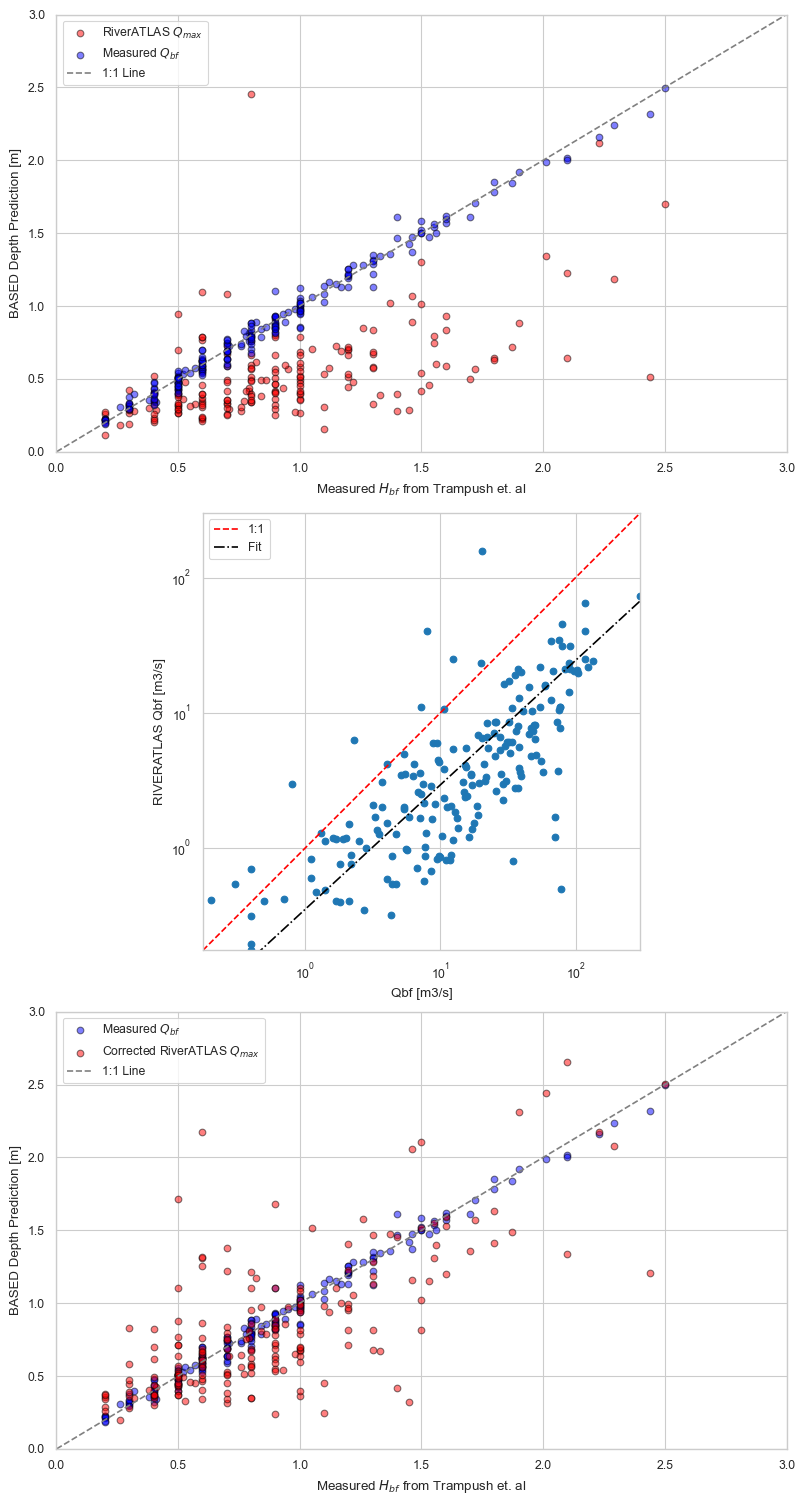

In [20]:
# Scatter plot for the first subplot
from scipy.optimize import curve_fit
plt.figure(figsize=(8, 15))

plt.subplot(3, 1, 1)
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
plt.plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
plt.xlabel('Measured $H_{bf}$ from Trampush et. al')
plt.ylabel('BASED Depth Prediction [m]')
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()

# Scatter plot for the second subplot
plt.subplot(3, 1, 2)
plt.scatter(gdf['Qbf [m3/s]'], gdf['RA_dis_m3_pmx_2'])
min_val = min(gdf['Qbf [m3/s]'].min(), gdf['RA_dis_m3_pmx_2'].min())
max_val = max(gdf['Qbf [m3/s]'].max(), gdf['RA_dis_m3_pmx_2'].max())
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1')
plt.xlabel('Qbf [m3/s]')
plt.ylabel('RA_dis_m3_pmx_2')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# Log-log scaling for the second subplot
plt.xscale('log')
plt.yscale('log')

# Fitting a power-law function for the second subplot
def power_law(x, a, b):
    return a * (x ** b)

x_data = gdf['Qbf [m3/s]'].values
y_data = gdf['RA_dis_m3_pmx_2'].values
params, covariance = curve_fit(power_law, x_data, y_data)

x_fit = np.linspace(min_val, max_val, 100)
y_fit = power_law(x_fit, *params)
plt.plot(x_fit, y_fit, color='black', ls='-.', label='Fit')
plt.ylabel("RIVERATLAS Qbf [m3/s]")
plt.legend()

# Create a new subplot for the corrected values scatter plot
plt.subplot(3, 1, 3)
def inverse_power_law(y, a, b):
    return (y / a) ** (1 / b)
gdf['corrected_discharge'] = inverse_power_law(gdf['RA_dis_m3_pmx_2'], *params)
guesswork1 = gdf[['Wbf [m]', 'S [-]', 'corrected_discharge']].astype(float)
gdf['XGB_depth_RA_corr'] = xgb_reg.predict(guesswork1)
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA_corr'], alpha=0.5, c='r', edgecolor='k', label='Corrected RiverATLAS $Q_{max}$')

plt.plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
plt.xlabel('Measured $H_{bf}$ from Trampush et. al')
plt.ylabel('BASED Depth Prediction [m]')
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()

# Show the entire figure
plt.tight_layout()
plt.savefig("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/trampiush_discharge.pdf")
plt.show()


NameError: name 'y_test' is not defined

<Figure size 500x1000 with 0 Axes>

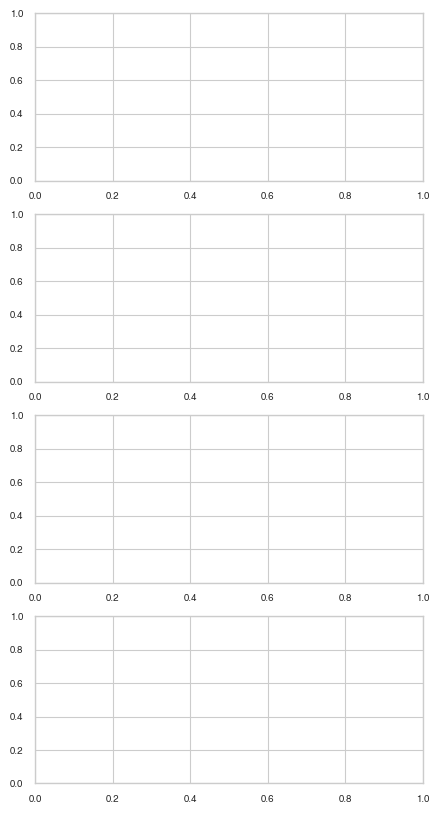

In [12]:
# Set up plot style
plt.figure(figsize=(5, 10))
sns.set_style('whitegrid')

# Set up fonts
rcParams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'pdf.fonttype': 42,
    'ps.fonttype': 42
}


matplotlib.rcParams.update(rcParams)
matplotlib.rcParams.update({
    'font.size': 9,              # Main font size
    'axes.labelsize': 9,         # Axes label font size
    'axes.titlesize': 9,         # Title font size
    'xtick.labelsize': 7,        # X-tick font size
    'ytick.labelsize': 7,        # Y-tick font size
    'legend.fontsize': 7,        # Legend font size
})

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Scatter plot for predicted vs actual values
axs[0].scatter(y_test, depth_predictions, color='red', edgecolor='k', s=20, alpha=0.5)
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label=f'1:1 line, n = {len(y_test)}', lw=1.5)
axs[0].set_xlabel('Measured Channel Depth (m)')
axs[0].set_ylabel('Predicted Channel Depth (m)')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
min_val, max_val = min(min(y_test), min(depth_predictions)), max(max(y_test), max(depth_predictions))
axs[0].set_xlim(min_val, max_val)
axs[0].set_ylim(min_val, max_val)
axs[0].set_aspect('equal', adjustable='box')
axs[0].legend()

# Scatter plot for the first subplot
axs[1].scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
axs[1].scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
axs[1].plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
axs[1].set_xlabel('Measured $H_{bf}$ from Trampush et. al')
axs[1].set_ylabel('BASED Depth Prediction [m]')
axs[1].grid(True)
axs[1].set_xlim(0, 3)
axs[1].set_ylim(0, 3)
axs[1].legend()
axs[1].set_xlim(0, 3)
axs[1].set_ylim(0, 3)
axs[1].set_aspect('equal', adjustable='box')

# Scatter plot for the second subplot
axs[2].scatter(gdf['Qbf [m3/s]'], gdf['RA_dis_m3_pmx_2'])
min_val = min(gdf['Qbf [m3/s]'].min(), gdf['RA_dis_m3_pmx_2'].min())
max_val = max(gdf['Qbf [m3/s]'].max(), gdf['RA_dis_m3_pmx_2'].max())
axs[2].set_xlim(min_val, max_val)
axs[2].set_ylim(min_val, max_val)
axs[2].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1')
axs[2].set_xlabel('Qbf [m3/s]')
axs[2].set_ylabel('RA_dis_m3_pmx_2')
axs[2].grid(True)
axs[2].set_aspect('equal', adjustable='box')
axs[2].legend()

# Log-log scaling for the second subplot
axs[2].set_xscale('log')
axs[2].set_yscale('log')

# Fitting a power-law function for the second subplot
def power_law(x, a, b):
    return a * (x ** b)

x_data = gdf['Qbf [m3/s]'].values
y_data = gdf['RA_dis_m3_pmx_2'].values
params, covariance = curve_fit(power_law, x_data, y_data)

x_fit = np.linspace(min_val, max_val, 100)
y_fit = power_law(x_fit, *params)
axs[2].plot(x_fit, y_fit, color='black', ls='-.', label='Fit')
axs[2].set_ylabel("RIVERATLAS Qbf [m3/s]")
axs[2].legend()

# Create a new subplot for the corrected values scatter plot
axs[3].scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
axs[3].scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA_corr'], alpha=0.5, c='r', edgecolor='k', label='Corrected RiverATLAS $Q_{max}$')
axs[3].plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
axs[3].set_xlabel('Measured $H_{bf}$ from Trampush et. al')
axs[3].set_ylabel('BASED Depth Prediction [m]')
axs[3].grid(True)
axs[3].legend()
# For the fourth plot
axs[3].set_xlim(0, 3)
axs[3].set_ylim(0, 3)
axs[3].set_aspect('equal', adjustable='box')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/trampiush_discharge.png", dpi=300)

# Show the figure
plt.show()

KeyError: 'XGB_depth_RA'

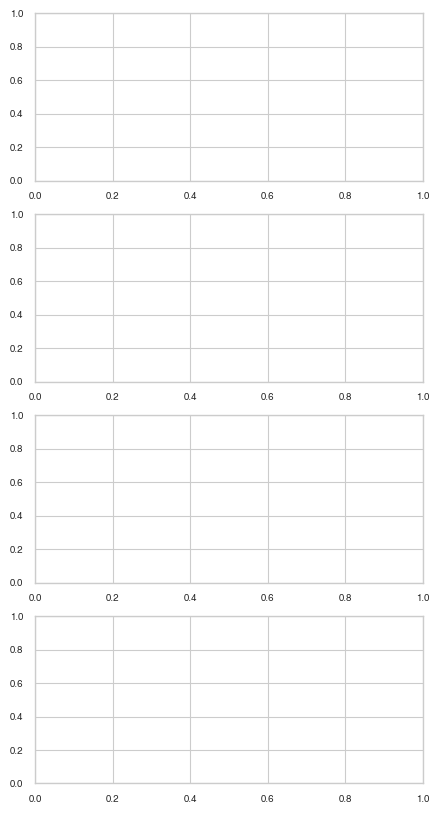

In [13]:

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 10))

# Scatter plot for the first subplot
axs[0].scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
axs[0].scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
axs[0].plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
axs[0].set_xlabel('Measured $H_{bf}$ from Trampush et. al')
axs[0].set_ylabel('BASED Depth Prediction [m]')
axs[0].grid(True)
axs[0].set_xlim(0, 3)
axs[0].set_ylim(0, 3)
axs[0].legend()
axs[0].set_xlim(0, 3)
axs[0].set_ylim(0, 3)
axs[0].set_aspect('equal', adjustable='box')
axs[0].text(-0.1, 1.1, 'A', transform=axs[0].transAxes, size=20, weight='bold')

# Scatter plot for the second subplot
axs[1].scatter(gdf['Qbf [m3/s]'], gdf['RA_dis_m3_pmx_2'])
min_val = min(gdf['Qbf [m3/s]'].min(), gdf['RA_dis_m3_pmx_2'].min())
max_val = max(gdf['Qbf [m3/s]'].max(), gdf['RA_dis_m3_pmx_2'].max())
axs[1].set_xlim(min_val, max_val)
axs[1].set_ylim(min_val, max_val)
axs[1].plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1')
axs[1].set_xlabel('Qbf [m3/s]')
axs[1].set_ylabel('RA_dis_m3_pmx_2')
axs[1].grid(True)
axs[1].set_aspect('equal', adjustable='box')
axs[1].legend()
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].text(-0.1, 1.1, 'B', transform=axs[1].transAxes, size=20, weight='bold')
axs[1].plot(x_fit, y_fit, color='black', ls='-.', label='Fit')


# Create a new subplot for the corrected values scatter plot
axs[2].scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
axs[2].scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA_corr'], alpha=0.5, c='r', edgecolor='k', label='Corrected RiverATLAS $Q_{max}$')
axs[2].plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
axs[2].set_xlabel('Measured $H_{bf}$ from Trampush et. al')
axs[2].set_ylabel('BASED Depth Prediction [m]')
axs[2].grid(True)
axs[2].legend()
axs[2].set_xlim(0, 3)
axs[2].set_ylim(0, 3)
axs[2].set_aspect('equal', adjustable='box')
axs[2].text(-0.1, 1.1, 'C', transform=axs[2].transAxes, size=20, weight='bold')

# Scatter plot for predicted vs actual values
axs[3].scatter(y_test, depth_predictions, color='red', edgecolor='k', s=20, alpha=0.5)
axs[3].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label=f'1:1 line, n = {len(y_test)}', lw=1.5)
axs[3].set_xlabel('Measured Channel Depth (m)')
axs[3].set_ylabel('Predicted Channel Depth (m)')
axs[3].set_yscale('log')
axs[3].set_xscale('log')
min_val, max_val = min(min(y_test), min(depth_predictions)), max(max(y_test), max(depth_predictions))
axs[3].set_xlim(min_val, max_val)
axs[3].set_ylim(min_val, max_val)
axs[3].set_aspect('equal', adjustable='box')
axs[3].legend()
axs[3].text(-0.1, 1.1, 'D', transform=axs[3].transAxes, size=20, weight='bold')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/trampiush_discharge.png", dpi=300)

# Show the figure
plt.show()


/Users/jakegearon/opt/anaconda3/envs/geo2/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


MAE: 0.256201
RMSE: 0.462216
R2: 0.979394


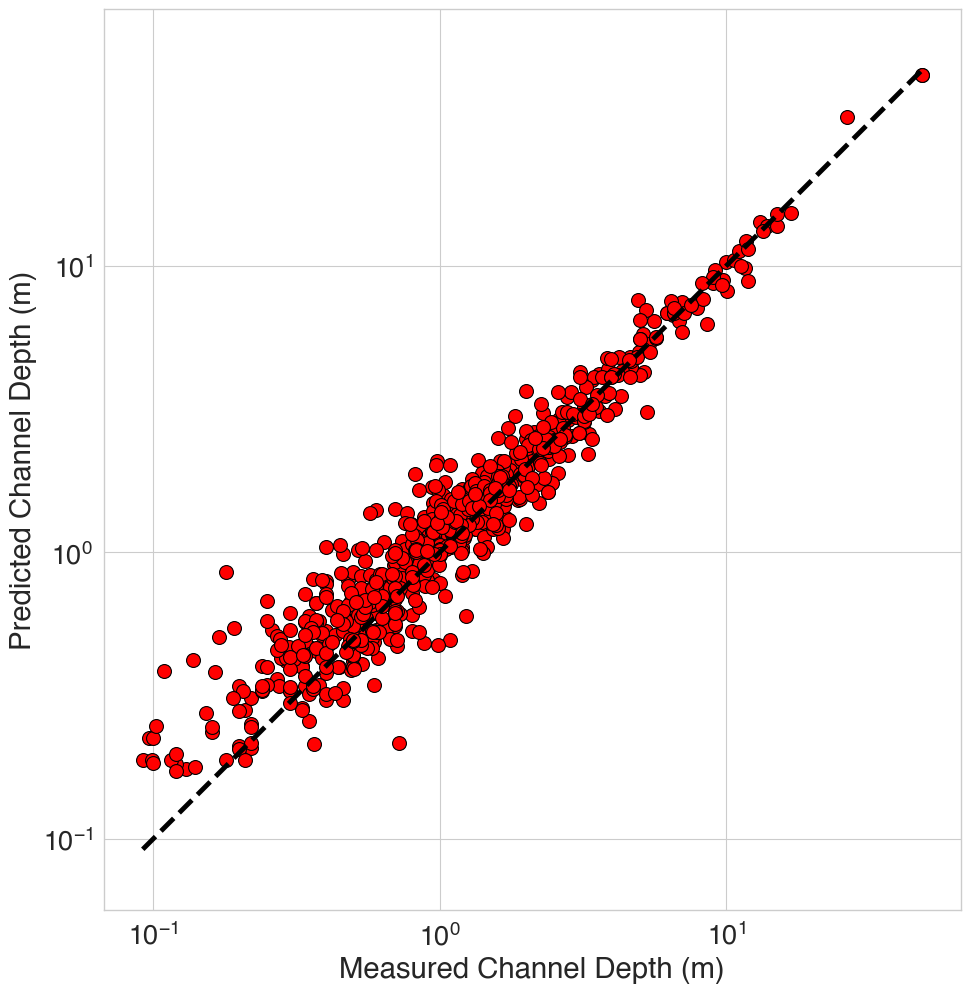

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV

# Set Seaborn style and font scale
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.2)

# Load the data
df = pd.read_csv("/Users/jakegearon/PycharmProjects/based_api/data/based_input_data_no_fulton.csv").drop("Unnamed: 0", axis=1)
df = df[df['discharge']>0]
#df = df[~df['source'].str.contains('Trampush', case=False, na=False)]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop("depth", axis=1), df["depth"], test_size=0.20, random_state=42, shuffle=True)
X_train = X_train.filter(["width", "slope", "discharge",], axis=1)
X_test = X_test.filter(["width", "slope", "discharge",], axis=1)
# Load the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.load_model("/Users/jakegearon/PycharmProjects/based_api/based_us_finetuned_with_early_stopping_combat_overfitting.pkl")

# Predict on the test set
depth_predictions = xgb_reg.predict(X_test)

# Evaluation Metrics
mae = metrics.mean_absolute_error(y_test, depth_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, depth_predictions))
r2 = metrics.r2_score(y_test, depth_predictions)

print("MAE: %f" % mae)
print("RMSE: %f" % rmse)
print("R2: %f" % r2)

# Set up plot style
plt.figure(figsize=(10,10))
sns.set_style('whitegrid')
plt.axis('equal')
plt.tight_layout()

# Set up fonts
rcParams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'pdf.fonttype': 42,
    'ps.fonttype': 42
}
matplotlib.rcParams.update(rcParams)

# Scatter plot for predicted vs actual values
sns.scatterplot(x=y_test, y=depth_predictions, color='red', edgecolor='k', s=100)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label=f'1:1 line, n = {len(y_test)}', lw=3.5)
plt.xlabel('Measured Channel Depth (m)')
plt.ylabel('Predicted Channel Depth (m)')
plt.yscale('log')
plt.xscale('log')

# Save the plots
# plt.savefig("img/BASED_US_P_validation.png", dpi=300)
# plt.savefig("img/BASED_US_P_validation.pdf")

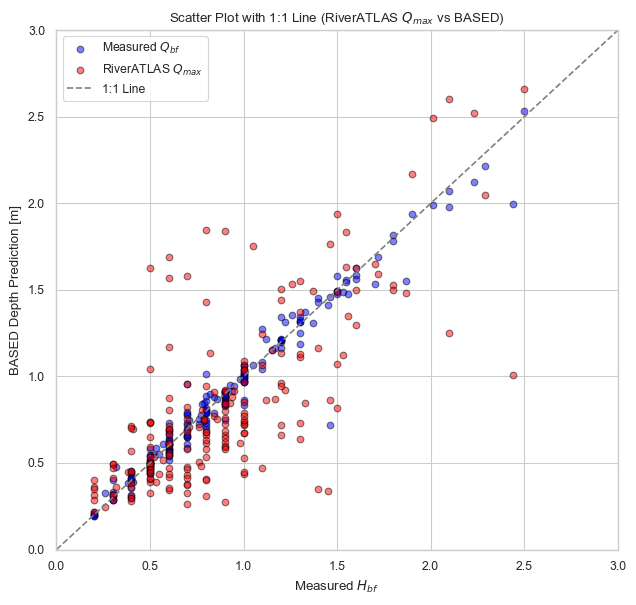

In [234]:

# Apply the power-law correction to the discharge values

# Scatter plot for the first subplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA_corr'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')

plt.plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
plt.xlabel('Measured $H_{bf}$')
plt.ylabel('BASED Depth Prediction [m]')
plt.grid(True)
#plt.loglog()

plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()
plt.title('Scatter Plot with 1:1 Line (RiverATLAS $Q_{max}$ vs BASED)')

# Show the entire figure
plt.tight_layout()
plt.show()



In [194]:
import pandas as pd

# Replace 'gdf' with your actual DataFrame if it's not defined already

# Calculate the absolute percentage error for each column
gdf['XGB_depth_RA_corr']  gdf['Hbf [m]']

# Calculate the mean absolute percentage error
mape_mean = gdf['MAPE_XGB_depth_RA_corr'].mean()

print("Mean Absolute Percentage Error:", mape_mean)


Mean Absolute Percentage Error: 32.35858325051533


Text(0.5, 1.0, 'Scatter Plot with 1:1 Line (Qbf vs RA_dis_m3_pmx_2)')

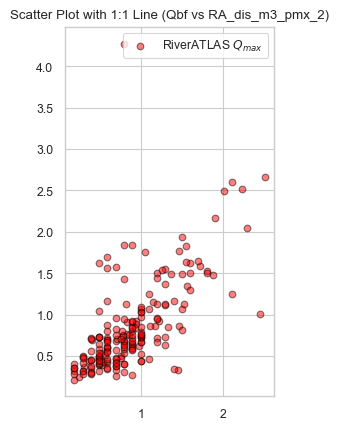

In [233]:


plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA_corr'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('Scatter Plot with 1:1 Line (Qbf vs RA_dis_m3_pmx_2)')

# Log-log scaling for the second subplot
#plt.xscale('log')
#plt.yscale('log')
#plt.plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')


Text(0.5, 1.0, 'Scatter Plot with 1:1 Line (RiverATLAS $Q_{max}$ vs BASED)')

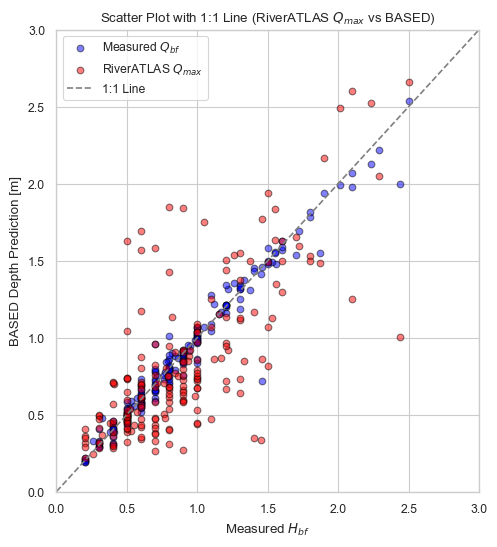

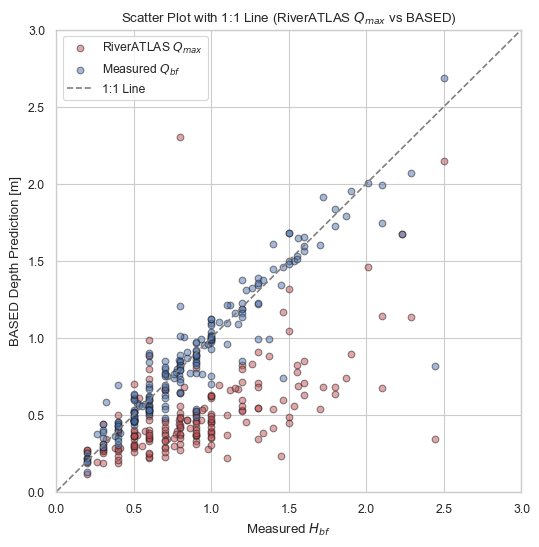

In [725]:
plt.figure(figsize=(6, 6))
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_RA'], alpha=0.5, c='r', edgecolor='k', label='RiverATLAS $Q_{max}$')
plt.scatter(gdf['Hbf [m]'], gdf['XGB_depth_VAL'], alpha=0.5, c='b', edgecolor='k', label='Measured $Q_{bf}$')
plt.plot([0, 3], [0, 3], linestyle='--', color='gray', label='1:1 Line')
plt.xlabel('Measured $H_{bf}$')
plt.ylabel('BASED Depth Prediction [m]')
plt.grid(True)
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()
plt.title('Scatter Plot with 1:1 Line (RiverATLAS $Q_{max}$ vs BASED)')
plt.show()


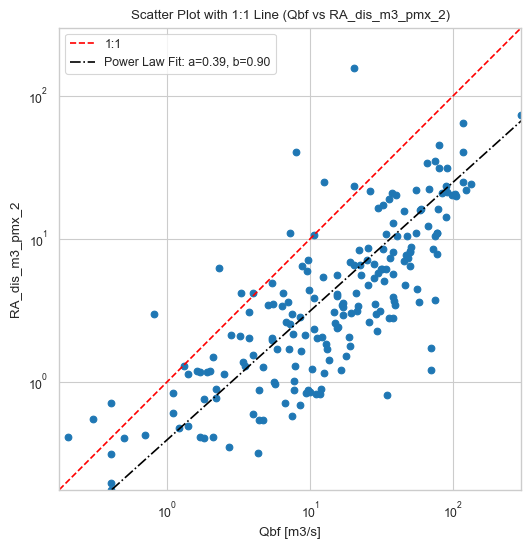

In [195]:
plt.figure(figsize=(6, 6))
plt.scatter(gdf['Qbf [m3/s]'], gdf['RA_dis_m3_pmx_2'])
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1')
plt.xlabel('Qbf [m3/s]')
plt.ylabel('RA_dis_m3_pmx_2')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('Scatter Plot with 1:1 Line (Qbf vs RA_dis_m3_pmx_2)')
plt.xscale('log')
plt.yscale('log')
plt.plot(x_fit, y_fit, color='black', ls='-.', label=f'Power Law Fit: a={params[0]:.2f}, b={params[1]:.2f}')
plt.legend()
plt.show()


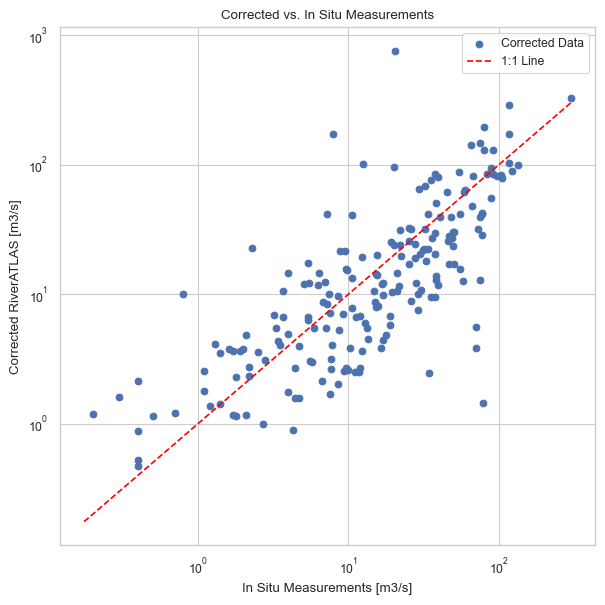

In [734]:
plt.figure(figsize=(6, 6))
# Scatter plot of corrected values vs in situ measurements
plt.scatter(gdf['Qbf [m3/s]'], gdf['corrected_discharge'], label='Corrected Data')
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label='1:1 Line')
plt.xlabel('In Situ Measurements [m3/s]')
plt.ylabel('Corrected RiverATLAS [m3/s]')
plt.title('Corrected vs. In Situ Measurements')
plt.legend()
plt.loglog()
plt.grid(True)

# Show the entire figure
plt.tight_layout()
plt.show()



In [628]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Metrics
mae = mean_absolute_error(gdf['Qbf [m3/s]'], gdf['corrected_RA'])
rmse = mean_squared_error(gdf['Qbf [m3/s]'], gdf['corrected_RA'], squared=False)
r2 = r2_score(gdf['Qbf [m3/s]'], gdf['corrected_RA'])
bias = gdf['residuals'].mean()
percent_bias = 100 * bias / gdf['Qbf [m3/s]'].mean()

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Bias: {bias:.2f}")
print(f"Percent Bias: {percent_bias:.2f}%")


MAE: 19.72
RMSE: 59.93
R-squared: -1.90
Bias: 3.19
Percent Bias: 11.08%


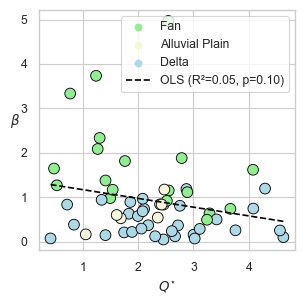

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib

palette = ['#90EE90', '#F5F5DC', '#ADD8E6']
sns.set_context('paper', font_scale=1.0)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 5
def inverse_power_law(y, a, b):
    return (y / a) ** (1 / b)

# Apply the power-law correction to the discharge values
df['corrected_discharge_mean'] = inverse_power_law(df['discharge_mean'], *params)
df['corrected_discharge_min'] = inverse_power_law(df['discharge_min'], *params)
df['newdis'] = (df['corrected_discharge'] - df['corrected_discharge_min'])/df['corrected_discharge_mean']
tdf = df.copy().dropna(subset=['newdis', 'superelevation_ov_mean'])
# Assuming you have already defined 'newdis' and loaded other columns from your DataFrame

# Create a scatter plot
plt.figure(figsize=(3, 3))  # Adjust the figure size as needed

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(tdf['newdis'], tdf['superelevation_ov_mean'])

# # Plot the scatter plot
sns.scatterplot(x=tdf['newdis'], y=tdf['superelevation_ov_mean'], hue=tdf['Geomorphology'], s=60,
                palette=palette, hue_order=['Fan', 'Alluvial Plain', 'Delta'], edgecolor='k')

# Plot the linear regression line
x_range = np.linspace(min(tdf['newdis']), max(tdf['newdis']), 100)
y_pred = slope * x_range + intercept
plt.plot(x_range, y_pred, color='black', linestyle='--', label=f'OLS (R²={r_value**2:.2f}, p={p_value:.2f})')

# Add a legend with R² and p-value
plt.legend()

# Customize plot labels, titles, and aesthetics as needed
plt.xlabel(r'$Q^{\star}$')
plt.ylabel(r'$\beta$', rotation=0)
#plt.title('Scatter Plot with Linear Regression Fit')
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/jakegearon/PycharmProjects/NatureGeoSubmission/submission/Q_var_no_corr.png', dpi=300)
# Show the plot
plt.show()
